In [1]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd

import acquire

/Users/seanoslin/codeup-data-science/ds-methodologies-exercises/nlp/acquire.py:21: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 21 of the file /Users/seanoslin/codeup-data-science/ds-methodologies-exercises/nlp/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.content)


In [3]:
from pprint import pprint

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def basic_clean(string):
    """
    Lowercase the string
    Normalize unicode characters
    Replace anything that is not a letter, number, whitespace or a single quote.
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
     # remove anything not a space character, an apostrophy, letter, or number
    string = re.sub(r"[^a-z0-9'\s]", '', string)
    
    string = string.strip()
    return string

In [10]:
def tokenize(s):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(s, return_str=True)

In [11]:
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': "codeup's data science program wa created in response to a "
            'percieved lack of data science talent and growing demand',
 'description': "codeup's data science program teach hand on skill using "
                'python and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


In [13]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


In [14]:
tfs = []

# We'll caclulate the tf-idf value for every word across every document

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the tf and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False))

,word,doc,tf_idf
11,python,description,0.250000
10,panda,description,0.250000
9,using,description,0.250000
8,hand,description,0.250000
7,teach,description,0.250000
4,skill,description,0.250000
16,response,context,0.176471
13,to,context,0.176471
4,demand,context,0.176471
3,created,context,0.176471


In [15]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

word,18,a,and,announced,codeup,codeup's,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.55%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   107
spam          2   491
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



In [19]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.41%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    39
spam         1   110
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.74      0.85       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115



In [21]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [22]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

In [23]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [26]:
y_pred = clf.predict(X_train)
y_pred[0:25]

array(['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
       'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam',
       'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam'], dtype=object)

In [27]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[1.        , 0.        ],
       [0.95230689, 0.04769311],
       [0.95230689, 0.04769311],
       ...,
       [0.95230689, 0.04769311],
       [0.95230689, 0.04769311],
       [0.95230689, 0.04769311]])

In [28]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.95


In [29]:
confusion_matrix(y_train, y_pred)

array([[3843,   16],
       [ 229,  369]])

In [31]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      3859
        spam       0.96      0.62      0.75       598

    accuracy                           0.95      4457
   macro avg       0.95      0.81      0.86      4457
weighted avg       0.95      0.95      0.94      4457



In [32]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.95


In [35]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [39]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [40]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [41]:
print(rf.feature_importances_)

[0.00183806 0.00981146 0.         ... 0.         0.         0.        ]


In [44]:
y_pred = rf.predict(X_train)
y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [45]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.88912961, 0.11087039],
       [0.86878971, 0.13121029],
       [0.88689104, 0.11310896],
       ...,
       [0.88788542, 0.11211458],
       [0.86500572, 0.13499428],
       [0.88363421, 0.11636579]])

In [46]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.86


In [47]:
print(confusion_matrix(y_train, y_pred))

[[3368    0]
 [ 532    0]]


In [48]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.86      1.00      0.93      3368
        spam       0.00      0.00      0.00       532

    accuracy                           0.86      3900
   macro avg       0.43      0.50      0.46      3900
weighted avg       0.75      0.86      0.80      3900



In [49]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.87


In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [52]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [53]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [54]:
y_pred = knn.predict(X_train)

In [55]:
y_pred_proba = knn.predict_proba(X_train)

In [56]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.97


In [57]:
print(confusion_matrix(y_train, y_pred))

[[3368    0]
 [ 122  410]]


In [58]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      3368
        spam       1.00      0.77      0.87       532

    accuracy                           0.97      3900
   macro avg       0.98      0.89      0.93      3900
weighted avg       0.97      0.97      0.97      3900



In [59]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.96


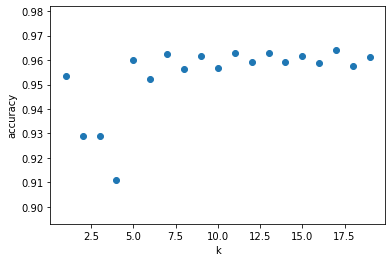

In [60]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)